In [1]:
import numpy as np # linear algebra

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import pickle
from itertools import islice

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [3]:
# Enable GPU memory growth to avoid OOM errors
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        print("Error enabling memory growth:", e)


Memory growth enabled for GPUs.


In [4]:
image_path ='input\\flickr30k_images\\Images'

In [5]:
import pandas as pd

# Read the CSV file with a specified delimiter (e.g., tab)
data = pd.read_csv(f"input\\flickr30k_images\\results.csv", sep='|')

# Display the first few rows of the dataframe
print(data.head())

       image_name  comment_number  \
0  1000092795.jpg               0   
1  1000092795.jpg               1   
2  1000092795.jpg               2   
3  1000092795.jpg               3   
4  1000092795.jpg               4   

                                             comment  
0  Two young guys with shaggy hair look at their ...  
1  Two young , White males are outside near many ...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  


In [6]:
# # Filter the data to include only the first 10 unique images
# num_images = 10
# unique_images = data['image_name'].unique()[:num_images]
# filtered_data = data[data['image_name'].isin(unique_images)].reset_index(drop=True)

# # Verify the filtered dataset
# print(f"Filtered dataset contains {len(filtered_data)} rows corresponding to {num_images} images.")
# print(filtered_data.head())

# # Proceed with the rest of your pipeline using `filtered_data` instead of `data`

In [6]:
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(f"input\\flickr30k_images\\Images\\{temp_df.image_name[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.comment[i], 20)))
        plt.axis("off")

In [7]:
print(data.columns)


Index(['image_name', 'comment_number', 'comment'], dtype='object')


In [9]:
data

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"Two young , White males are outside near many ..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ove...
158911,998845445.jpg,1,"A young man hanging over the side of a boat , ..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue and...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with f..."


In [8]:
def text_preprocessing(data):
    data['comment'] = data['comment'].apply(lambda x: x.lower())
    data['comment'] = data['comment'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['comment'] = data['comment'].apply(lambda x: x.replace("\s+"," "))
    data['comment'] = data['comment'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['comment'] = "startseq "+data['comment']+" endseq"
    return data

In [9]:
print(data.columns)


Index(['image_name', 'comment_number', 'comment'], dtype='object')


In [10]:
# Check for missing values in the 'comment' column
missing_values = data[data['comment'].isnull()]

# Display rows with missing values
print("Rows with missing values in the 'comment' column:")
print(missing_values)


Rows with missing values in the 'comment' column:
Empty DataFrame
Columns: [image_name, comment_number, comment]
Index: []


In [11]:
# Identify rows where 'comment' is not a string
non_string_values = data[~data['comment'].apply(lambda x: isinstance(x, str))]

# Display rows with non-string values
print("Rows with non-string values in the 'comment' column:")
print(non_string_values)


Rows with non-string values in the 'comment' column:
Empty DataFrame
Columns: [image_name, comment_number, comment]
Index: []


In [12]:
# Identify rows with missing or non-string values
invalid_values = data[data['comment'].isnull() | ~data['comment'].apply(lambda x: isinstance(x, str))]

# Display invalid rows
print("Rows with missing or non-string values in the 'comment' column:")
print(invalid_values)


Rows with missing or non-string values in the 'comment' column:
Empty DataFrame
Columns: [image_name, comment_number, comment]
Index: []


In [13]:
data = text_preprocessing(data)
comments = data['comment'].tolist()
comments[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(comments)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(comment.split()) for comment in comments)

images = data['image_name'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image_name'].isin(train_images)]
test = data[data['image_name'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([comments[1]])[0]

[1, 12, 21, 20, 708, 13, 54, 79, 194, 1421, 2]

In [15]:
# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        print("Error enabling memory growth:", e)


Memory growth enabled for GPUs.


In [17]:
features_file = "features_efficientnetb0.pkl"  # Name for saving features
img_size = 128  # Image size for feature extraction
batch_size = 64  # Batch size to optimize GPU usage

# Initialize EfficientNetB0 model without the top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
output = base_model.output
output = GlobalAveragePooling2D()(output)
fe = tf.keras.Model(inputs=base_model.input, outputs=output)

In [18]:
from PIL import UnidentifiedImageError

if os.path.exists(features_file):
    # Load features if the file exists
    with open(features_file, "rb") as f:
        features = pickle.load(f)
    print("Features loaded successfully from existing file.")
else:
    features = {}  # Initialize an empty dictionary to store features
    all_images = [f for f in os.listdir(image_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]

    for i in tqdm(range(0, len(all_images), batch_size), desc="Processing batches"):
        batch_images = []
        batch_image_names = all_images[i:i + batch_size]

        for image in batch_image_names:
            img_path = os.path.join(image_path, image)
            if not os.path.exists(img_path):
                print(f"Image not found: {img_path}")
                continue

            try:
                img = load_img(img_path, target_size=(img_size, img_size))
                img = img_to_array(img)
                img = preprocess_input(img)
                batch_images.append(img)
            except UnidentifiedImageError:
                print(f"Skipping invalid image file: {img_path}")

        if not batch_images:
            continue

        batch_images = np.array(batch_images)

        with tf.device('/GPU:0'):
            batch_features = fe.predict(batch_images, verbose=0)

        for idx, image in enumerate(batch_image_names):
            features[image] = batch_features[idx]

    # Save computed features to file
    with open(features_file, "wb") as f:
        pickle.dump(features, f)
    print("Features computed and saved to file.")


Features loaded successfully from existing file.


In [19]:
# Verify the features by displaying a few entries
from itertools import islice

print("Verifying extracted features...")
for image_name, feature_array in islice(features.items(), 5):
    print(f"Image: {image_name}, Feature Shape: {feature_array.shape}")

print("Feature extraction completed!")


Verifying extracted features...
Image: 1000092795.jpg, Feature Shape: (4, 4, 1280)
Image: 10002456.jpg, Feature Shape: (4, 4, 1280)
Image: 1000268201.jpg, Feature Shape: (4, 4, 1280)
Image: 1000344755.jpg, Feature Shape: (4, 4, 1280)
Image: 1000366164.jpg, Feature Shape: (4, 4, 1280)
Feature extraction completed!


In [20]:
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer,
                 vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return int(np.ceil(self.n / self.batch_size))
    
    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y
    
    def __get_data(self, batch):
        X1, X2, y = [], [], []
        for idx in batch.index:
            image = batch.loc[idx, self.X_col]
            comment = batch.loc[idx, self.y_col]
            feature = self.features[image]
            seq = self.tokenizer.texts_to_sequences([comment])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)  # Use the class index directly (not one-hot)
        X1 = np.array(X1)
        X2 = np.array(X2)
        y = np.array(y)  # Class indices
        return X1, X2, y


In [21]:
input1 = Input(shape=(1280,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

comment_model = Model(inputs=[input1,input2], outputs=output)
comment_model.compile(loss='categorical_crossentropy',optimizer='adam')

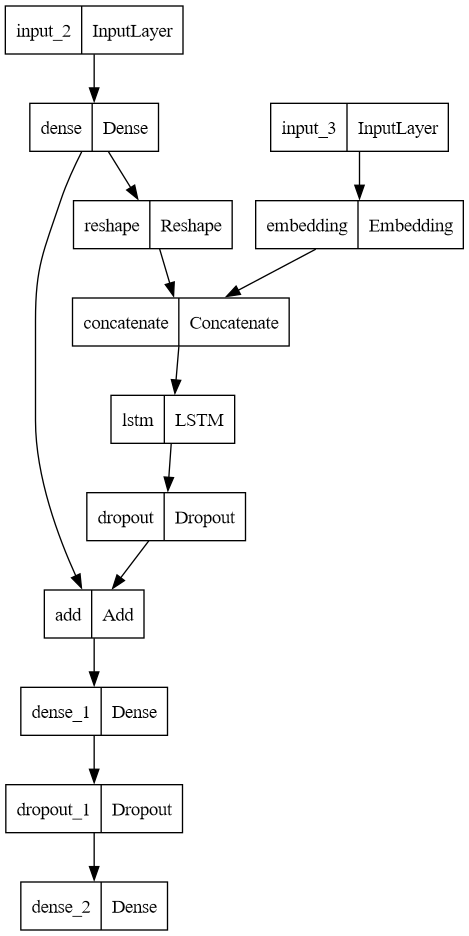

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(comment_model)

In [23]:
comment_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          327936      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

In [24]:
train_generator = CustomDataGenerator(
    df=train,
    X_col='image_name',
    y_col='comment',
    batch_size=64,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
)

validation_generator = CustomDataGenerator(
    df=test,
    X_col='image_name',
    y_col='comment',
    batch_size=64,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
)

In [25]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [26]:
(X1, X2), y = train_generator[0]
print(f"X1 shape: {X1.shape}, X2 shape: {X2.shape}, y shape: {y.shape}")


X1 shape: (687, 4, 4, 1280), X2 shape: (687, 74), y shape: (687,)


In [29]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
from itertools import islice
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Reshape, Dropout, concatenate, add
from tensorflow.keras.models import Model

# GPU Setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        print("Error enabling memory growth:", e)
else:
    print("No GPU detected. Ensure CUDA and cuDNN are properly installed.")

# Convergence Stopping Callback
class ConvergenceStopping(Callback):
    def __init__(self, delta=0.01, patience=3):
        super(ConvergenceStopping, self).__init__()
        self.delta = delta
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        if abs(train_loss - val_loss) < self.delta:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nConvergence reached (train_loss: {train_loss}, val_loss: {val_loss}). Stopping training.")
                self.model.stop_training = True
        else:
            self.wait = 0

# Load Precomputed Features
features_file = "features_efficientnetb0.pkl"
if os.path.exists(features_file):
    with open(features_file, "rb") as f:
        features = pickle.load(f)
    print("Features loaded successfully.")
else:
    raise FileNotFoundError(f"{features_file} not found. Ensure feature extraction is completed.")

# Verify Features
print("Verifying extracted features...")
for image_name, feature_array in islice(features.items(), 5):
    print(f"Image: {image_name}, Feature Shape: {feature_array.shape}")

# Ensure Input Shapes
# Pool features into (1280) if not already pooled
for key in features.keys():
    if len(features[key].shape) == 3:  # Check if features are (4, 4, 1280)
        features[key] = np.mean(features[key], axis=(0, 1))  # Apply global pooling
print("Features pooled successfully to match input shape.")

input_dim = 1280  # Feature vector size
print(f"Model expects input feature dimension: {input_dim}")

# Define Model Architecture
input1 = Input(shape=(input_dim,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

comment_model = Model(inputs=[input1, input2], outputs=output)
comment_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Verify Model Summary
comment_model.summary()

# Data Generators
train_generator = CustomDataGenerator(
    df=train,
    X_col='image_name',
    y_col='comment',
    batch_size=64,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
)

validation_generator = CustomDataGenerator(
    df=test,
    X_col='image_name',
    y_col='comment',
    batch_size=64,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
)

# Callbacks
model_name = "model.keras"
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss', 
    patience=3, 
    verbose=1, 
    factor=0.2, 
    min_lr=1e-8
)

callbacks = [
    checkpoint,
    earlystopping,
    learning_rate_reduction,
    ConvergenceStopping(delta=0.01, patience=3)
]

Memory growth enabled for GPUs.
Features loaded successfully.
Verifying extracted features...
Image: 1000092795.jpg, Feature Shape: (4, 4, 1280)
Image: 10002456.jpg, Feature Shape: (4, 4, 1280)
Image: 1000268201.jpg, Feature Shape: (4, 4, 1280)
Image: 1000344755.jpg, Feature Shape: (4, 4, 1280)
Image: 1000366164.jpg, Feature Shape: (4, 4, 1280)
Features pooled successfully to match input shape.
Model expects input feature dimension: 1280
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          327936      ['input_4[0][0]']                
                                              

In [27]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("Using GPU:", tf.config.list_physical_devices('GPU')[0])
else:
    print("No GPU detected. Ensure CUDA and cuDNN are properly installed.")

Num GPUs Available:  1
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [28]:
import pickle

if not os.path.exists(model_name):
    print("Model does not exist. Training...")
    history = comment_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=callbacks
    )
    # Save the model after training
    comment_model.save(model_name)
    
    
    # Plot Training History
    plt.figure(figsize=(20, 8))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
    # Save the training history
    with open('training_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
else:
    print("Model already exists. Loading...")
    comment_model = tf.keras.models.load_model(model_name)
    # Load training history if available
    if os.path.exists('training_history.pkl'):
        with open('training_history.pkl', 'rb') as f:
            history_data = pickle.load(f)
            history = tf.keras.callbacks.History()
            history.history = history_data
    else:
        history = None


Model already exists. Loading...


In [29]:
if history is not None:
    plt.figure(figsize=(20, 8))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
else:
    print("Model was loaded from file. No training history available.")


Model was loaded from file. No training history available.


1/1 [==============================] - 49s 49s/step


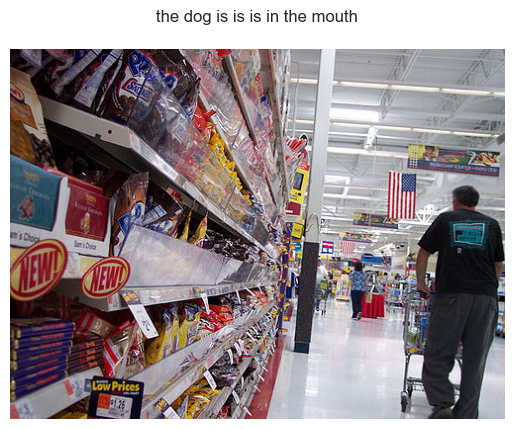

Predicted Caption: the dog is is is in the mouth


In [30]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt

# Load pre-trained InceptionV3 model for feature extraction
inception_model = InceptionV3(include_top=False, weights='imagenet')
pooling_layer = GlobalAveragePooling2D()

# Feature extraction function
def extract_image_features(image_path):
    # Load the InceptionV3 model pre-trained on ImageNet
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
    
    # Add GlobalAveragePooling and Dense layer to reduce dimensions
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1280)(x)  # Reduce to 1280 dimensions
    
    feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=x)
    
    # Load and preprocess the image
    img = load_img(image_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Extract features
    features = feature_extractor.predict(img_array)
    return features.flatten()

# Tokenizer utility functions
def idx_to_word(idx, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == idx:
            return word
    return None

# Beam search for better caption generation
def beam_search(model, feature, tokenizer, max_length, beam_width=3):
    sequences = [(0, ["startseq"])]  # Start with the sequence "startseq"
    
    for _ in range(max_length):
        all_candidates = []
        
        # Expand each sequence
        for score, seq in sequences:
            sequence = tokenizer.texts_to_sequences([" ".join(seq)])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            y_pred = model.predict([feature, sequence], verbose=0)[0]
            
            # Get top `beam_width` predictions
            top_candidates = np.argsort(y_pred)[-beam_width:]
            for idx in top_candidates:
                word = idx_to_word(idx, tokenizer)
                if word is None:
                    continue
                candidate = seq + [word]
                candidate_score = score - np.log(y_pred[idx])  # Lower score is better
                all_candidates.append((candidate_score, candidate))
        
        # Order all candidates by score
        sequences = sorted(all_candidates, key=lambda x: x[0])[:beam_width]
    
    # Return the sequence with the best score
    final_sequence = sequences[0][1]
    return " ".join(final_sequence).replace("startseq", "").replace("endseq", "").strip()

# Caption prediction function
def predict_comment(model, image_path, tokenizer, max_length):
    # Extract features for the new image
    feature = extract_image_features(image_path)
    
    # Reshape features to match model input
    feature = np.reshape(feature, (1, feature.shape[0]))
    
    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Predict the next word
        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        if word is None or word == "endseq":
            break
        in_text += " " + word
    
    return in_text.replace("startseq ", "")

# Visualization function
def visualize_with_caption(image_path, predicted_caption):
    img = load_img(image_path)
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(predicted_caption, fontsize=12, pad=20)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load trained model
    model_path = "model.keras"
    tokenizer_path = "tokenizer.pkl"  # Assuming tokenizer was saved as a pickle file

    if not os.path.exists(model_path):
        print("Trained model not found. Please ensure the model is trained and saved.")
    else:
        comment_model = tf.keras.models.load_model(model_path)
        
        # Load the tokenizer
        with open(tokenizer_path, "rb") as f:
            tokenizer = pickle.load(f)
        
        # Ensure max_length is consistent
        max_length = 74  # Set this to the same value used during training

        # Test on a new image
        test_image_path = "D:/College/Sem_5/Deep Learning/Project TRIAL/input/flickr30k_images/Images/854749.jpg"  # Replace with your image path
        predicted_caption = predict_comment(comment_model, test_image_path, tokenizer, max_length)

        # Visualize the image with the caption
        visualize_with_caption(test_image_path, predicted_caption)
        print(f"Predicted Caption: {predicted_caption}")

